In [1]:
# bne_llm_or_experiment.ipynb
"""
Purpose:

- Use the four-piece dataset generated in `brsb_data_generator.ipynb`

(`nodes.csv`, `facilities.csv`, `dist.csv`, `scenarios.json`)

- Build a transportation optimization model (Gurobi) for a multi-level (G1/G2/G3) lithium battery recycling network

- The experiment consists of three parts:

1. Baseline: Solve for optimal allocation and total cost under normal capacity

2. Disruption: Adjust capacity according to the disturbance scenarios (scenarios.json) generated by LLM, and compare costs with unmet demand

3. Sensitivity: Change key parameters (such as capacity discount, cost coefficient) and observe the impact on system resilience

Methodological Framework:

- LLM is responsible for: generating/parseing scenarios such as "which recycling center is having problems, how serious, and how long" at the text layer, and storing them. `scenarios.json`

- OR (Gurobi) is responsible for: solving the minimum transport cost problem for a multi-level recycling network given scenario parameters.

- This Notebook only performs **optimization and experimental analysis** and no longer calls the LLM API (LLM's work is indirectly reflected through `scenarios.json`).

Notes for supervisors:
    - All experiments are run in the dedicated virtual environment `llm_or_env`.
    - Data preprocessing is separated in `brsb_data_generator.ipynb` to ensure
      reproducibility (raw → processed four-file bundle).
"""
"""
# bne_llm_or_experiment.ipynb

Purpose / 目的：
- 使用在 `brsb_data_generator.ipynb` 中生成的四件套数据  
  （`nodes.csv`, `facilities.csv`, `dist.csv`, `scenarios.json`）
- 建立一个多等级（G1/G2/G3）锂电池回收网络的运输优化模型（Gurobi）
- 实验分为三部分：
  1. Baseline：在正常容量下，求解最优分配与总成本
  2. Disruption：按 LLM 生成的扰动场景（scenarios.json）调整容量，比较成本与未满足需求
  3. Sensitivity：改变关键参数（如容量折扣、成本系数），观察对系统韧性的影响

方法框架：
- LLM 负责：在文本层生成/解析「哪家回收中心出问题、多严重、多长时间」等场景，并存入 `scenarios.json`
- OR (Gurobi) 负责：在给定场景参数下，求解多等级回收网络的最小运输成本问题
- 本 Notebook 只做 **优化和实验分析**，不再调用 LLM API（LLM 的工作通过 `scenarios.json` 间接体现）。
"""


'\n# bne_llm_or_experiment.ipynb\n\nPurpose / 目的：\n- 使用在 `brsb_data_generator.ipynb` 中生成的四件套数据  \n  （`nodes.csv`, `facilities.csv`, `dist.csv`, `scenarios.json`）\n- 建立一个多等级（G1/G2/G3）锂电池回收网络的运输优化模型（Gurobi）\n- 实验分为三部分：\n  1. Baseline：在正常容量下，求解最优分配与总成本\n  2. Disruption：按 LLM 生成的扰动场景（scenarios.json）调整容量，比较成本与未满足需求\n  3. Sensitivity：改变关键参数（如容量折扣、成本系数），观察对系统韧性的影响\n\n方法框架：\n- LLM 负责：在文本层生成/解析「哪家回收中心出问题、多严重、多长时间」等场景，并存入 `scenarios.json`\n- OR (Gurobi) 负责：在给定场景参数下，求解多等级回收网络的最小运输成本问题\n- 本 Notebook 只做 **优化和实验分析**，不再调用 LLM API（LLM 的工作通过 `scenarios.json` 间接体现）。\n'

In [2]:
# Cell 1: Imports, paths, and load 4 core data files

import pandas as pd
import numpy as np
from pathlib import Path
import json

# 如果需要画图（后面 sensitivity 可以用）
import matplotlib.pyplot as plt

# 1) 路径设置（假设本 Notebook 和 brsb_data_generator.ipynb 在同一文件夹 Notebook1 下）
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"

print("BASE_DIR      :", BASE_DIR)
print("PROCESSED_DIR :", PROCESSED_DIR)

# 2) 读取四件套
nodes_path      = PROCESSED_DIR / "nodes.csv"
facilities_path = PROCESSED_DIR / "facilities.csv"
dist_path       = PROCESSED_DIR / "dist.csv"
scenarios_path  = PROCESSED_DIR / "scenarios.json"

nodes_df      = pd.read_csv(nodes_path)
facilities_df = pd.read_csv(facilities_path)
dist_df       = pd.read_csv(dist_path)

with open(scenarios_path, "r", encoding="utf-8") as f:
    scenarios = json.load(f)

print("\n[OK] Loaded files:")
print("nodes_df     :", nodes_df.shape)
print("facilities_df:", facilities_df.shape)
print("dist_df      :", dist_df.shape)
print("scenarios keys:", list(scenarios.keys()))

# 3) 简单清理：把节点和设施改成 index 方便后面建模
nodes_df = nodes_df.set_index("node_id")
facilities_df = facilities_df.set_index("facility_id")

# dist_df 的 index 已经是 node_id，列是 facility_id（如果不是，可以显式设置）
if "node_id" in dist_df.columns:
    dist_df = dist_df.set_index("node_id")

# 看一眼前几行，确认结构
display(nodes_df.head())
display(facilities_df.head())
display(dist_df.head())


BASE_DIR      : D:\Projects\llm_or_project\Notebook1
PROCESSED_DIR : D:\Projects\llm_or_project\Notebook1\data\processed

[OK] Loaded files:
nodes_df     : (5, 10)
facilities_df: (3, 13)
dist_df      : (5, 4)
scenarios keys: ['baseline', 'F01_40pct_5days', 'F02_80pct_10days', 'F03_60pct_7days']


,SA2_CODE,SA2_NAME,LAT,LON,POP,recycled_tonnes_total,grade_A_t,grade_B_t,grade_C_t
node_id,,,,,,,,,
N001,D01,Demo Area 1,-27.47,153.03,30000,97.573047,68.301133,24.393262,4.878652
N002,D02,Demo Area 2,-27.45,153.01,25000,81.310872,56.917611,20.327718,4.065544
N003,D03,Demo Area 3,-27.49,153.05,20000,65.048698,45.534089,16.262174,3.252435
N004,D04,Demo Area 4,-27.50,153.00,15000,48.786523,34.150566,12.196631,2.439326
N005,D05,Demo Area 5,-27.46,153.04,10000,32.524349,22.767044,8.131087,1.626217


,name,TYPE,LAT,LON,accept_A,accept_B,accept_C,capacity_total_t,cap_A_t,cap_B_t,cap_C_t,fixed_cost
facility_id,,,,,,,,,,,,
F01,Demo Recycling Center 1,recycling,-27.48,153.02,1,1,1,50.0,35.0,12.5,2.5,200
F02,Demo Remanufacturing Plant 1,remanufacturing,-27.44,153.04,1,1,0,30.0,21.0,7.5,0.0,250
F03,Demo Second-life Facility 1,second_life,-27.50,153.00,1,0,0,40.0,28.0,0.0,0.0,180


,F01,F02,F03
node_id,,,
N001,1783.800076,4174.462650,5351.186227
N002,4174.432191,3794.820600,6775.913505
N003,3793.614030,6775.932275,6066.694582
N004,3567.386172,9301.738135,0.000000
N005,3567.671441,2668.678239,7135.057557


In [3]:
# Cell 2: Define grade structure and high-level parameters

# 约定三个等级：A/B/C
GRADES = ["A", "B", "C"]

# 节点需求列名（来自 brsb_data_generator.ipynb）
GRADE_DEMAND_COL = {
    "A": "grade_A_t",
    "B": "grade_B_t",
    "C": "grade_C_t",
}

# 设施容量列名
GRADE_CAP_COL = {
    "A": "cap_A_t",
    "B": "cap_B_t",
    "C": "cap_C_t",
}

# 等级接受标记
ACCEPT_COL = {
    "A": "accept_A",
    "B": "accept_B",
    "C": "accept_C",
}

# 运输成本参数：每吨·公里的成本（可以在 sensitivity 部分调整）
TRANSPORT_COST_PER_TKM = {
    "A": 1.0,
    "B": 1.0,
    "C": 1.1,   # 假设危险性更高，稍贵一点
}

# 把 dist 的单位从 m 转成 km，用于成本计算
dist_km_df = dist_df.copy()
dist_km_df = dist_km_df.astype(float) / 1000.0

# 1) 计算总需求 & 总容量，检查模型是否可行
summary_rows = []
for g in GRADES:
    total_demand = nodes_df[GRADE_DEMAND_COL[g]].sum()
    total_capacity = facilities_df[GRADE_CAP_COL[g]].sum()
    summary_rows.append({
        "grade": g,
        "total_demand_t": total_demand,
        "total_capacity_t": total_capacity,
        "capacity_minus_demand": total_capacity - total_demand,
    })

system_summary = pd.DataFrame(summary_rows)
print("=== System demand vs capacity (baseline) ===")
display(system_summary)


=== System demand vs capacity (baseline) ===


,grade,total_demand_t,total_capacity_t,capacity_minus_demand
0,A,227.670443,84.0,-143.670443
1,B,81.310872,20.0,-61.310872
2,C,16.262174,2.5,-13.762174


In [4]:
# === Cell 3: 定义求解函数 + 跑一次 baseline 场景 ===

from gurobipy import Model, GRB, quicksum
import pandas as pd

def solve_bne_model(capacity_factor=None, unmet_penalty=10000, verbose=True):
    """
    Solve Brisbane battery-network model.

    Parameters
    ----------
    capacity_factor :
        - None        → 所有设施容量系数 = 1.0
        - float/int   → 所有设施容量统一乘以这个系数
        - dict        → {facility_id: 系数}，未给出的设施默认 1.0
    unmet_penalty : float
        每吨未满足需求的惩罚成本（统一对 A/B/C 适用）
    verbose : bool
        是否打印 Gurobi 日志

    Returns
    -------
    result : dict
        {
          "model":       m,             # Gurobi model 对象
          "status":      m.status,      # Gurobi 状态码
          "total_cost":  m.objVal,      # 目标值
          "total_unmet": total_unmet,   # 总未满足需求 (t)
          "util_df":     util_df        # 各设施各等级利用率表
        }
    """

    # -------- 0. 把 capacity_factor 统一变成 {facility_id: factor} 的 dict --------
    fac_ids = list(facilities_df.index)

    if capacity_factor is None:
        cap_factor = {fid: 1.0 for fid in fac_ids}

    elif isinstance(capacity_factor, (int, float)):
        cf = float(capacity_factor)
        cap_factor = {fid: cf for fid in fac_ids}

    elif isinstance(capacity_factor, dict):
        cap_factor = {}
        for fid in fac_ids:
            cap_factor[fid] = float(capacity_factor.get(fid, 1.0))
    else:
        raise TypeError(
            f"capacity_factor must be None, float/int or dict, got {type(capacity_factor)}"
        )

    # -------- 1. 准备数据 --------
    node_ids = list(nodes_df.index)
    grades = GRADES  # ["A", "B", "C"]

    # 需求 (t)
    demand = {
        (i, g): float(nodes_df.loc[i, GRADE_DEMAND_COL[g]])
        for i in node_ids
        for g in grades
    }

    # 设施容量 (t)（含接受约束 + capacity_factor）
    cap = {}
    for j in fac_ids:
        for g in grades:
            base_cap = float(facilities_df.loc[j, GRADE_CAP_COL[g]])
            accept   = int(facilities_df.loc[j, ACCEPT_COL[g]])
            eff_cap  = base_cap * cap_factor[j] * accept  # 不接受该等级时 accept=0
            cap[(j, g)] = eff_cap

    # 距离 (km)  dist_df: index=node_id, columns=facility_id
    dist_km = {
        (i, j): float(dist_df.loc[i, j])
        for i in node_ids
        for j in fac_ids
    }

    # 吨公里成本
    trans_cost = TRANSPORT_COST_PER_TKM  # dict: {"A":..., "B":..., "C":...}

    # -------- 2. 建立 Gurobi 模型 --------
    m = Model("bne_llm_or")
    m.Params.OutputFlag = 1 if verbose else 0

    # 决策变量：x[i,j,g] 运输量 (t)，u[i,g] 未满足需求 (t)
    x = {}
    for i in node_ids:
        for j in fac_ids:
            for g in grades:
                x[(i, j, g)] = m.addVar(lb=0.0, name=f"x_{i}_{j}_{g}")

    u = {}
    for i in node_ids:
        for g in grades:
            u[(i, g)] = m.addVar(lb=0.0, name=f"u_{i}_{g}")

    m.update()

    # -------- 3. 约束 --------
    # (a) 每个节点每个等级：供应 + 未满足 = 需求
    for i in node_ids:
        for g in grades:
            m.addConstr(
                quicksum(x[(i, j, g)] for j in fac_ids) + u[(i, g)] == demand[(i, g)],
                name=f"demand_{i}_{g}"
            )

    # (b) 每个设施每个等级：流入 ≤ 有效容量
    for j in fac_ids:
        for g in grades:
            if cap[(j, g)] > 0:
                m.addConstr(
                    quicksum(x[(i, j, g)] for i in node_ids) <= cap[(j, g)],
                    name=f"cap_{j}_{g}"
                )
            else:
                # 如果容量为 0，就强制 x = 0
                for i in node_ids:
                    m.addConstr(
                        x[(i, j, g)] == 0.0,
                        name=f"cap_zero_{i}_{j}_{g}"
                    )

    # -------- 4. 目标函数：运输成本 + 未满足惩罚 --------
    transport_term = quicksum(
        x[(i, j, g)] * dist_km[(i, j)] * trans_cost[g]
        for i in node_ids
        for j in fac_ids
        for g in grades
    )

    unmet_term = unmet_penalty * quicksum(
        u[(i, g)] for i in node_ids for g in grades
    )

    m.setObjective(transport_term + unmet_term, GRB.MINIMIZE)

    # -------- 5. 求解 --------
    m.optimize()

    status = m.status
    total_cost = float(m.ObjVal) if status == GRB.OPTIMAL else None

    # 总未满足需求
    total_unmet = 0.0
    if status == GRB.OPTIMAL:
        total_unmet = sum(u[(i, g)].X for i in node_ids for g in grades)

    # -------- 6. 生成利用率表 util_df --------
    util_rows = []
    if status == GRB.OPTIMAL:
        for j in fac_ids:
            for g in grades:
                flow = sum(x[(i, j, g)].X for i in node_ids)
                cap_t = cap[(j, g)]
                util = flow / cap_t if cap_t > 0 else 0.0
                util_rows.append({
                    "facility_id": j,
                    "grade":      g,
                    "flow_t":     flow,
                    "cap_t":      cap_t,
                    "utilization": util,
                })

    util_df = pd.DataFrame(util_rows)

    result = {
        "model":       m,
        "status":      status,
        "total_cost":  total_cost,
        "total_unmet": total_unmet,
        "util_df":     util_df,
    }

    return result


# ===== 在同一个 Cell 里：跑一次 baseline，并把结果保存为全局变量 =====

print("=== Solving baseline Brisbane battery-network model ===")

# 和你之前敏感性分析保持一致的基准惩罚
unmet_penalty_base = 10000  

baseline_res = solve_bne_model(
    capacity_factor=1.0,          # baseline: 不调整容量
    unmet_penalty=unmet_penalty_base,
    verbose=False
)

print("Type of baseline_res:", type(baseline_res))
print("Keys in baseline_res:", baseline_res.keys())

if baseline_res["status"] == GRB.OPTIMAL:
    baseline_cost  = baseline_res["total_cost"]
    baseline_unmet = baseline_res["total_unmet"]

    print(f"Baseline model status: {baseline_res['status']}")
    print(f"Baseline total cost: {baseline_cost:,.2f}")
    print(f"Baseline unmet demand (t): {baseline_unmet:.4f}")
    display(baseline_res["util_df"])
else:
    print("Baseline model not optimal. Status =", baseline_res["status"])


=== Solving baseline Brisbane battery-network model ===
Set parameter Username
Set parameter LicenseID to value 2737110
Type of baseline_res: <class 'dict'>
Keys in baseline_res: dict_keys(['model', 'status', 'total_cost', 'total_unmet', 'util_df'])
Baseline model status: 2
Baseline total cost: 2,353,128.18
Baseline unmet demand (t): 218.7435


,facility_id,grade,flow_t,cap_t,utilization
0,F01,A,35.0,35.0,1.0
1,F01,B,12.5,12.5,1.0
2,F01,C,2.5,2.5,1.0
3,F02,A,21.0,21.0,1.0
4,F02,B,7.5,7.5,1.0
5,F02,C,0.0,0.0,0.0
6,F03,A,28.0,28.0,1.0
7,F03,B,0.0,0.0,0.0
8,F03,C,0.0,0.0,0.0


In [5]:
# Cell 4: Run disruption scenarios from scenarios.json

"""
Objective:

- Utilize the scenarios.json file defined in brsb_data_generator.ipynb

- Solve the Gurobi model once for each "capacity-impaired scenario"

- Output a summary table: total cost / unmet requirements / additional cost relative to the baseline

This will allow for direct inclusion in the Disruption section of the paper.
目的：
- 利用在 brsb_data_generator.ipynb 中写好的 scenarios.json
- 对每一个“容量受损场景”分别求解一次 Gurobi 模型
- 输出一张 summary 表：总成本 / 未满足需求 / 相对 baseline 的额外成本
  方便直接放进论文的 Disruption 章节
"""

def run_capacity_scenario(name, scen_dict, unmet_penalty=1e4, verbose=False):
    """
    name: Scene name (key in scenes.json)

   scen_dict: The dictionary corresponding to this scene (containing affected_center, capacity_factor, etc.)

    unmet_penalty: The penalty coefficient per ton for unmet requirements, defaulting to the baseline

    Returns:

    row: A single row of results (dict) used for the summary DataFrame

    res: The complete return result of solve_bne_model (including util_df, etc.)
     
     
    name:        场景名字（scenarios.json 的 key）
    scen_dict:   该场景对应的 dict（包含 affected_center, capacity_factor 等）
    unmet_penalty: 未满足需求每吨的惩罚系数，默认与 baseline 一致

    返回：
      row  : 用于 summary DataFrame 的一行结果（dict）
      res  : solve_bne_model 的完整返回结果（包含 util_df 等）
    """
    # 1) 解析场景信息（字段名按你在 brsb_data_generator 里写的来）
    fac = scen_dict["affected_center"]          # 例如 "F01"
    factor = float(scen_dict["capacity_factor"])
    summary_zh = scen_dict.get("summary_zh", "")
    duration_days = scen_dict.get("duration_days", None)

    # 2) 构造 capacity_factor 字典：默认都是 1.0，只有受影响的设施打折
    cap_factor = {fid: 1.0 for fid in facilities_df.index}
    if fac not in cap_factor:
        print(f"[WARN] Scenario {name}: affected_center={fac} 不在 facilities 表中，跳过此场景。")
        # 返回一个“未求解”的行
        row = {
            "scenario": name,
            "summary_zh": summary_zh,
            "affected_center": fac,
            "capacity_factor": factor,
            "duration_days": duration_days,
            "status": "INVALID_FACILITY",
        }
        return row, None

    cap_factor[fac] = factor

    # 3) 调用前面写好的 solve_bne_model
    res = solve_bne_model(
        capacity_factor=cap_factor,
        unmet_penalty=unmet_penalty,
        verbose=verbose
    )

    # 4) 汇总结果到一行 dict，方便后面做 DataFrame
    row = {
        "scenario": name,
        "summary_zh": summary_zh,
        "affected_center": fac,
        "capacity_factor": factor,
        "duration_days": duration_days,
        "status": res["status"],
    }

    if res["status"] == GRB.OPTIMAL:
        row["total_cost"] = res["total_cost"]
        row["total_unmet_t"] = res["total_unmet"]
        row["extra_cost_vs_baseline"] = res["total_cost"] - baseline_res["total_cost"]
    else:
        row["total_cost"] = None
        row["total_unmet_t"] = None
        row["extra_cost_vs_baseline"] = None

    return row, res


# ================== 实际跑所有 disruption 场景 ==================

scenario_rows = []
scenario_models = {}   # 保存每个场景的完整求解结果（包括 util_df）

for name, s in scenarios.items():
    # 可选：如果你在 json 里定义了 "baseline" 场景，这里可以跳过
    if name.lower().startswith("baseline"):
        continue

    print(f"\n=== Solving scenario: {name} ===")
    row, res = run_capacity_scenario(name, s, unmet_penalty=1e4, verbose=False)
    scenario_rows.append(row)
    if res is not None:
        scenario_models[name] = res

# 汇总成 DataFrame
scenario_df = pd.DataFrame(scenario_rows)

print("\n=== Disruption scenarios summary (sorted by extra_cost_vs_baseline) ===")
# 按额外成本从小到大排序（也可以改成按 total_unmet_t 排序）
scenario_df_sorted = scenario_df.sort_values(
    by=["extra_cost_vs_baseline"], ascending=True, na_position="last"
)
display(scenario_df_sorted)

# 可选：简单查看某个场景下的利用率分布
if len(scenario_models) > 0:
    example_name = list(scenario_models.keys())[0]
    print(f"\n[Example] Utilization table for scenario: {example_name}")
    display(scenario_models[example_name]["util_df"])

# 汇总 DataFrame
scenario_df  = pd.DataFrame(scenario_rows)

print("\n=== Disruption scenarios summary (sorted by extra_cost_vs_baseline) ===")
scenario_df_sorted = scenario_df.sort_values(
    by=["extra_cost_vs_baseline"], ascending=True, na_position="last"
)
display(scenario_df_sorted)

# 让后续 Cell11 能直接使用
disruption_df = scenario_df_sorted




=== Solving scenario: F01_40pct_5days ===

=== Solving scenario: F02_80pct_10days ===

=== Solving scenario: F03_60pct_7days ===

=== Disruption scenarios summary (sorted by extra_cost_vs_baseline) ===


,scenario,summary_zh,affected_center,capacity_factor,duration_days,status,total_cost,total_unmet_t,extra_cost_vs_baseline
1,F02_80pct_10days,场景2：设施 Demo Remanufacturing Plant 1（F02）计划维护，未...,F02,0.8,10,2,2.394917e+06,224.44349,41788.534035
2,F03_60pct_7days,场景3：设施 Demo Second-life Facility 1（F03）位于偏远区域，...,F03,0.6,7,2,2.465128e+06,229.94349,112000.000000
0,F01_40pct_5days,场景1：设施 Demo Recycling Center 1（F01）发生故障，未来5天处理...,F01,0.4,5,2,2.599347e+06,248.74349,246218.427719



[Example] Utilization table for scenario: F01_40pct_5days


,facility_id,grade,flow_t,cap_t,utilization
0,F01,A,14.0,14.0,1.0
1,F01,B,5.0,5.0,1.0
2,F01,C,1.0,1.0,1.0
3,F02,A,21.0,21.0,1.0
4,F02,B,7.5,7.5,1.0
5,F02,C,0.0,0.0,0.0
6,F03,A,28.0,28.0,1.0
7,F03,B,0.0,0.0,0.0
8,F03,C,0.0,0.0,0.0



=== Disruption scenarios summary (sorted by extra_cost_vs_baseline) ===


,scenario,summary_zh,affected_center,capacity_factor,duration_days,status,total_cost,total_unmet_t,extra_cost_vs_baseline
1,F02_80pct_10days,场景2：设施 Demo Remanufacturing Plant 1（F02）计划维护，未...,F02,0.8,10,2,2.394917e+06,224.44349,41788.534035
2,F03_60pct_7days,场景3：设施 Demo Second-life Facility 1（F03）位于偏远区域，...,F03,0.6,7,2,2.465128e+06,229.94349,112000.000000
0,F01_40pct_5days,场景1：设施 Demo Recycling Center 1（F01）发生故障，未来5天处理...,F01,0.4,5,2,2.599347e+06,248.74349,246218.427719


In [6]:
# Cell 5: Sensitivity analysis on unmet_penalty

"""
目的：
- 在不改变容量的情况下，只调整未满足需求的惩罚系数 unmet_penalty
- 观察 “总成本 / 未满足需求量” 随 penalty 的变化
- 为论文里的 Sensitivity 章节提供一张清晰的表格
"""

penalty_list = [2_000, 5_000, 10_000, 20_000, 50_000]

sens_rows = []
sens_models = {}

for p in penalty_list:
    print(f"\n=== Solving sensitivity run: unmet_penalty = {p:,.0f} ===")
    res = solve_bne_model(
        capacity_factor=None,   # 不改容量，只改惩罚
        unmet_penalty=p,
        verbose=False
    )

    row = {
        "unmet_penalty": p,
        "status": res["status"],
    }

    if res["status"] == GRB.OPTIMAL:
        row["total_cost"] = res["total_cost"]
        row["total_unmet_t"] = res["total_unmet"]

        # 和 baseline 对比（baseline_res 是前面 Cell 3 保存的）
        row["extra_cost_vs_baseline"] = res["total_cost"] - baseline_res["total_cost"]

        # 一个粗略的“平均利用率”指标（所有 facility & grade 的平均）
        util_df = res["util_df"]
        row["avg_utilization"] = util_df["utilization"].mean()
    else:
        row["total_cost"] = None
        row["total_unmet_t"] = None
        row["extra_cost_vs_baseline"] = None
        row["avg_utilization"] = None

    sens_rows.append(row)
    sens_models[p] = res

# 汇总成 DataFrame
sens_df = pd.DataFrame(sens_rows).sort_values("unmet_penalty")

print("\n=== Sensitivity on unmet_penalty (vs baseline penalty = 10,000) ===")
display(sens_df)



=== Solving sensitivity run: unmet_penalty = 2,000 ===

=== Solving sensitivity run: unmet_penalty = 5,000 ===

=== Solving sensitivity run: unmet_penalty = 10,000 ===

=== Solving sensitivity run: unmet_penalty = 20,000 ===

=== Solving sensitivity run: unmet_penalty = 50,000 ===

=== Sensitivity on unmet_penalty (vs baseline penalty = 10,000) ===


,unmet_penalty,status,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
0,2000,2,5.841229e+05,247.24349,-1.769005e+06,0.444444
1,5000,2,1.259411e+06,218.74349,-1.093717e+06,0.666667
2,10000,2,2.353128e+06,218.74349,0.000000e+00,0.666667
3,20000,2,4.540563e+06,218.74349,2.187435e+06,0.666667
4,50000,2,1.110287e+07,218.74349,8.749740e+06,0.666667


In [7]:
# === Cell 6: Sensitivity analysis on capacity_factor (capacity scaling) ===

print("=== Cell 6: Sensitivity analysis on capacity_factor (capacity scaling) ===\n")

# 1) 检查前置结果（baseline_res 一定要已经算好）
required_vars = ["baseline_res", "facilities_df"]
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"Required variable '{v}' not found. "
                           "Please run previous cells (baseline & model definition) first.")

# 2) 读取 baseline 结果（方便做对比）
print("Type of baseline_res:", type(baseline_res))
print("Keys in baseline_res:", list(baseline_res.keys()))

baseline_cost  = baseline_res["total_cost"]
baseline_unmet = baseline_res.get("total_unmet_t", None)

print(f"Baseline total cost: {baseline_cost:,.2f}")
if baseline_unmet is not None:
    print(f"Baseline unmet demand (t): {baseline_unmet:.4f}\n")
else:
    print("Baseline unmet demand (t): not available in baseline_res\n")

# 3) 设置敏感性实验的 capacity_factor 取值
#    解释：0.60 = 所有设施容量缩短到 60%；1.50 = 放大到 150%
capacity_values = [0.60, 0.80, 1.00, 1.20, 1.50]

# 保持与 Cell 5 一样的罚系数基准（如果你改过，这里同步改）
unmet_penalty_base = 10000.0

sensitivity_rows = []

for cf in capacity_values:
    print(f"=== Solving sensitivity run: capacity_factor = {cf:.2f} ===")

    # 调用同一个求解函数，只是传入不同的 capacity_factor（标量）
    res = solve_bne_model(
        capacity_factor=cf,                # 关键：容量整体缩放系数
        unmet_penalty=unmet_penalty_base,  # 其他参数保持与 baseline 一致
        verbose=False
    )

    status = res["status"]
    total_cost = res["total_cost"]
    total_unmet = res.get("total_unmet_t", None)

    # 设施利用率的平均值（便于看系统是否“吃紧”）
    if "util_df" in res and ("utilization" in res["util_df"].columns):
        avg_util = float(res["util_df"]["utilization"].mean())
    else:
        avg_util = None

    extra_cost = total_cost - baseline_cost

    sensitivity_rows.append({
        "capacity_factor": cf,
        "status":         status,
        "total_cost":     total_cost,
        "total_unmet_t":  total_unmet,
        "extra_cost_vs_baseline": extra_cost,
        "avg_utilization": avg_util,
    })

# 4) 汇总成表格，按 capacity_factor 排序输出
sens_cap_df = pd.DataFrame(sensitivity_rows)
sens_cap_df = sens_cap_df.sort_values(by="capacity_factor").reset_index(drop=True)

print("\n=== Sensitivity on capacity_factor (vs baseline factor = 1.00) ===")
display(sens_cap_df)


=== Cell 6: Sensitivity analysis on capacity_factor (capacity scaling) ===

Type of baseline_res: <class 'dict'>
Keys in baseline_res: ['model', 'status', 'total_cost', 'total_unmet', 'util_df']
Baseline total cost: 2,353,128.18
Baseline unmet demand (t): not available in baseline_res

=== Solving sensitivity run: capacity_factor = 0.60 ===
=== Solving sensitivity run: capacity_factor = 0.80 ===
=== Solving sensitivity run: capacity_factor = 1.00 ===
=== Solving sensitivity run: capacity_factor = 1.20 ===
=== Solving sensitivity run: capacity_factor = 1.50 ===

=== Sensitivity on capacity_factor (vs baseline factor = 1.00) ===


,capacity_factor,status,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
0,0.6,2,2.712851e+06,None,359722.686549,0.666667
1,0.8,2,2.532990e+06,None,179861.343275,0.666667
2,1.0,2,2.353128e+06,None,0.000000,0.666667
3,1.2,2,2.176985e+06,None,-176142.969305,0.666667
4,1.5,2,1.958825e+06,None,-394302.686128,0.666667


Baseline total cost: 2,353,128.18
Baseline unmet demand (t): 218.7435

[INFO] sens_penalty_df not found – rerunning unmet_penalty sensitivity ...
=== Solving sensitivity run: unmet_penalty = 2,000 ===
=== Solving sensitivity run: unmet_penalty = 5,000 ===
=== Solving sensitivity run: unmet_penalty = 10,000 ===
=== Solving sensitivity run: unmet_penalty = 20,000 ===
=== Solving sensitivity run: unmet_penalty = 50,000 ===

=== Sensitivity on unmet_penalty (vs baseline penalty) ===


,unmet_penalty,status,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
0,2000,2,5.841229e+05,247.24349,-1.769005e+06,0.444444
1,5000,2,1.259411e+06,218.74349,-1.093717e+06,0.666667
2,10000,2,2.353128e+06,218.74349,0.000000e+00,0.666667
3,20000,2,4.540563e+06,218.74349,2.187435e+06,0.666667
4,50000,2,1.110287e+07,218.74349,8.749740e+06,0.666667



=== Sensitivity on capacity_factor (vs baseline factor = 1.00) ===


,capacity_factor,status,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
0,0.6,2,2.712851e+06,None,359722.686549,0.666667
1,0.8,2,2.532990e+06,None,179861.343275,0.666667
2,1.0,2,2.353128e+06,None,0.000000,0.666667
3,1.2,2,2.176985e+06,None,-176142.969305,0.666667
4,1.5,2,1.958825e+06,None,-394302.686128,0.666667



Saved Table 7a to: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_sensitivity_unmet_penalty.csv
Saved Table 7b to: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_sensitivity_capacity_factor.csv


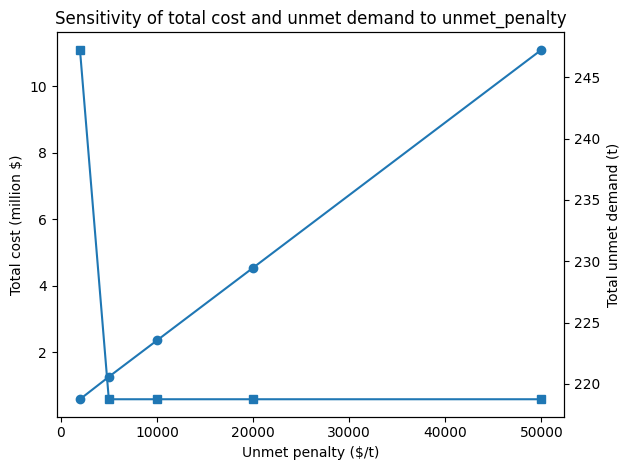

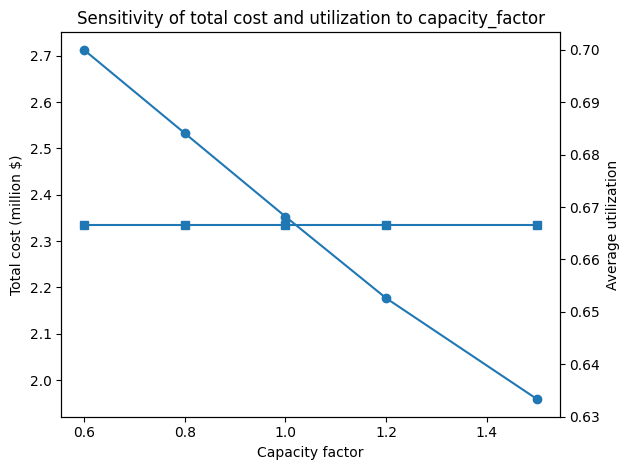

In [8]:
# ==== Cell 7: Prepare sensitivity tables & plots for the paper ====
import pandas as pd
import matplotlib.pyplot as plt

# 小工具：兼容 total_unmet_t / total_unmet 两种命名
def get_total_unmet(res: dict) -> float:
    if "total_unmet_t" in res:
        return res["total_unmet_t"]
    if "total_unmet" in res:
        return res["total_unmet"]
    raise KeyError("Result dict has neither 'total_unmet_t' nor 'total_unmet'.")

# 1) 确保 baseline 结果存在（若不存在就自动重算）
if "baseline_res" not in globals():
    print("[INFO] baseline_res not found, recomputing baseline model ...")
    if "unmet_penalty_base" not in globals():
        unmet_penalty_base = 10000  # 和前面基准设置保持一致即可
    baseline_res = solve_bne_model(
        capacity_factor=1.0,
        unmet_penalty=unmet_penalty_base,
        verbose=False,
    )

baseline_cost = baseline_res["total_cost"]
baseline_unmet = get_total_unmet(baseline_res)
print(f"Baseline total cost: {baseline_cost:,.2f}")
print(f"Baseline unmet demand (t): {baseline_unmet:.4f}\n")

# 2) 若 sens_penalty_df 不存在，则在此重新做“罚成本”敏感性实验
if "sens_penalty_df" not in globals():
    print("[INFO] sens_penalty_df not found – rerunning unmet_penalty sensitivity ...")
    penalty_values = [2000, 5000, 10000, 20000, 50000]
    rows = []
    for p in penalty_values:
        print(f"=== Solving sensitivity run: unmet_penalty = {p:,.0f} ===")
        res = solve_bne_model(
            capacity_factor=1.0,
            unmet_penalty=p,
            verbose=False,
        )
        util_df = res["util_df"]
        avg_util = util_df["utilization"].mean()
        rows.append({
            "unmet_penalty": p,
            "status": res["status"],
            "total_cost": res["total_cost"],
            "total_unmet_t": get_total_unmet(res),
            "extra_cost_vs_baseline": res["total_cost"] - baseline_cost,
            "avg_utilization": avg_util,
        })
    sens_penalty_df = pd.DataFrame(rows)

# 3) 若 sens_cap_df 不存在，则在此重新做“产能缩放”敏感性实验
if "sens_cap_df" not in globals():
    print("\n[INFO] sens_cap_df not found – rerunning capacity_factor sensitivity ...")
    cap_values = [0.4,0.6, 0.8, 1.0, 1.2]
    if "unmet_penalty_base" not in globals():
        unmet_penalty_base = 10000

    rows = []
    for cf in cap_values:
        print(f"=== Solving sensitivity run: capacity_factor = {cf:.2f} ===")
        res = solve_bne_model(
            capacity_factor=cf,
            unmet_penalty=unmet_penalty_base,
            verbose=False,
        )
        util_df = res["util_df"]
        avg_util = util_df["utilization"].mean()
        rows.append({
            "capacity_factor": cf,
            "status": res["status"],
            "total_cost": res["total_cost"],
            "total_unmet_t": get_total_unmet(res),
            "extra_cost_vs_baseline": res["total_cost"] - baseline_cost,
            "avg_utilization": avg_util,
        })
    sens_cap_df = pd.DataFrame(rows)

# 4) 整理成“论文表格版”并保存 CSV（Table 7a / 7b）

print("\n=== Sensitivity on unmet_penalty (vs baseline penalty) ===")
tbl_penalty_out = sens_penalty_df[[
    "unmet_penalty",
    "status",
    "total_cost",
    "total_unmet_t",
    "extra_cost_vs_baseline",
    "avg_utilization",
]].copy()
display(tbl_penalty_out)

print("\n=== Sensitivity on capacity_factor (vs baseline factor = 1.00) ===")
tbl_cap_out = sens_cap_df[[
    "capacity_factor",
    "status",
    "total_cost",
    "total_unmet_t",
    "extra_cost_vs_baseline",
    "avg_utilization",
]].copy()
display(tbl_cap_out)

pen_table_path = PROCESSED_DIR / "tbl_sensitivity_unmet_penalty.csv"
cap_table_path = PROCESSED_DIR / "tbl_sensitivity_capacity_factor.csv"
tbl_penalty_out.to_csv(pen_table_path, index=False)
tbl_cap_out.to_csv(cap_table_path, index=False)

print("\nSaved Table 7a to:", pen_table_path)
print("Saved Table 7b to:", cap_table_path)

# 5) 画两张敏感性折线图（方便直接截图进论文）

# 5.1 unmet_penalty → total_cost & total_unmet_t
fig, ax1 = plt.subplots()
ax1.plot(
    tbl_penalty_out["unmet_penalty"],
    tbl_penalty_out["total_cost"] / 1e6,
    marker="o",
)
ax1.set_xlabel("Unmet penalty ($/t)")
ax1.set_ylabel("Total cost (million $)")

ax2 = ax1.twinx()
ax2.plot(
    tbl_penalty_out["unmet_penalty"],
    tbl_penalty_out["total_unmet_t"],
    marker="s",
)
ax2.set_ylabel("Total unmet demand (t)")
plt.title("Sensitivity of total cost and unmet demand to unmet_penalty")
fig.tight_layout()

# 5.2 capacity_factor → total_cost & avg_utilization
fig2, ax3 = plt.subplots()
ax3.plot(
    tbl_cap_out["capacity_factor"],
    tbl_cap_out["total_cost"] / 1e6,
    marker="o",
)
ax3.set_xlabel("Capacity factor")
ax3.set_ylabel("Total cost (million $)")

ax4 = ax3.twinx()
ax4.plot(
    tbl_cap_out["capacity_factor"],
    tbl_cap_out["avg_utilization"],
    marker="s",
)
ax4.set_ylabel("Average utilization")
plt.title("Sensitivity of total cost and utilization to capacity_factor")
fig2.tight_layout()


Saved Figure 8a to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_sensitivity_unmet_penalty.png
Saved Figure 8b to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_sensitivity_capacity_factor.png


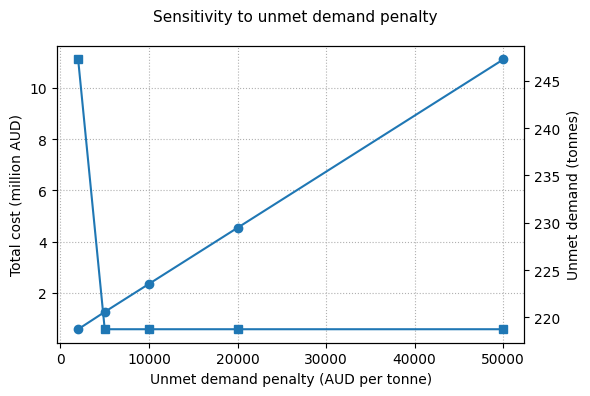

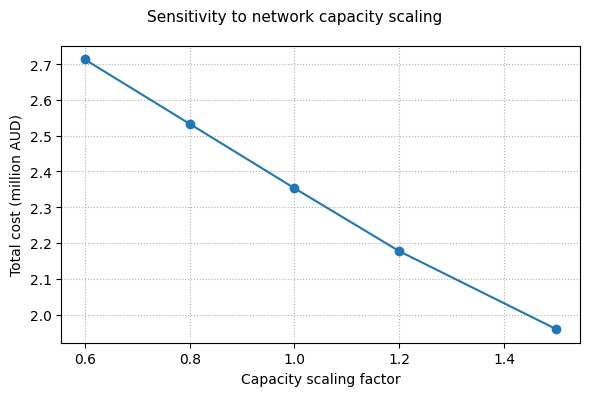

In [9]:
# === Cell 8: Figures for sensitivity analyses (ready for paper) ===

import matplotlib.pyplot as plt

if "sens_penalty_df" not in globals() or "sens_cap_df" not in globals():
    raise RuntimeError("sens_penalty_df / sens_cap_df 未找到，请先运行前面 Cell5 / Cell6。")

# 保证按参数从小到大画线
pen_df = sens_penalty_df.sort_values("unmet_penalty").copy()
cap_df = sens_cap_df.sort_values("capacity_factor").copy()

# ---------- 图 8a：未满足需求惩罚，对总成本 & 未满足需求的影响 ----------

fig1, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(
    pen_df["unmet_penalty"],
    pen_df["total_cost"] / 1e6,
    marker="o",
)
ax1.set_xlabel("Unmet demand penalty (AUD per tonne)")
ax1.set_ylabel("Total cost (million AUD)")
ax1.grid(True, linestyle=":")

ax2 = ax1.twinx()
ax2.plot(
    pen_df["unmet_penalty"],
    pen_df["total_unmet_t"],
    marker="s",
)
ax2.set_ylabel("Unmet demand (tonnes)")

fig1.suptitle("Sensitivity to unmet demand penalty", fontsize=11)
fig1.tight_layout()

fig1_path = PROCESSED_DIR / "fig_sensitivity_unmet_penalty.png"
fig1.savefig(fig1_path, dpi=300, bbox_inches="tight")
print("Saved Figure 8a to:", fig1_path)


# ---------- 图 8b：容量缩放，对总成本 / 额外成本的影响 ----------

fig2, ax3 = plt.subplots(figsize=(6, 4))

ax3.plot(
    cap_df["capacity_factor"],
    cap_df["total_cost"] / 1e6,
    marker="o",
)
ax3.set_xlabel("Capacity scaling factor")
ax3.set_ylabel("Total cost (million AUD)")
ax3.grid(True, linestyle=":")

fig2.suptitle("Sensitivity to network capacity scaling", fontsize=11)
fig2.tight_layout()

fig2_path = PROCESSED_DIR / "fig_sensitivity_capacity_factor.png"
fig2.savefig(fig2_path, dpi=300, bbox_inches="tight")
print("Saved Figure 8b to:", fig2_path)

plt.show()


In [10]:
# === Cell 9: run_scenario_from_dict —— LLM → JSON → OR 主入口 ===

import numbers
from copy import deepcopy

def _build_capacity_factor_map(scenario_dict, facilities_df):
    """

    Generate a capacity_factor mapping passed to solve_bne_model based on scenario_dict.

Three syntaxes are supported (they can be mixed, with the latter overriding the former):

1) Uniform coefficient:

"capacity_factor": 0.8

2) Explicit dictionary:

"capacity_factor_map": {"F01": 0.4, "F02": 1.2}

3) List-based modifications:

"capacity_changes": [
{"facility_id": "F01", "factor": 0.4},

{"facility_id": "F02", "factor": 1.2}

]

    
    
    根据 scenario_dict 生成传给 solve_bne_model 的 capacity_factor 映射。

    支持三种写法（可以混用，后者会覆盖前者）：
    1）统一系数：
        "capacity_factor": 0.8
    2）显式字典：
        "capacity_factor_map": {"F01": 0.4, "F02": 1.2}
    3）列表形式的修改：
        "capacity_changes": [
            {"facility_id": "F01", "factor": 0.4},
            {"facility_id": "F02", "factor": 1.2}
        ]
    """
    # 先给所有设施一个默认值 1.0
    cap_map = {fid: 1.0 for fid in facilities_df.index}

    # 1) 全局统一缩放
    if "capacity_factor" in scenario_dict and isinstance(
        scenario_dict["capacity_factor"], numbers.Real
    ):
        global_factor = float(scenario_dict["capacity_factor"])
        cap_map = {fid: global_factor for fid in cap_map}

    # 2) 设施级映射（字典）
    if isinstance(scenario_dict.get("capacity_factor_map"), dict):
        for fid, f in scenario_dict["capacity_factor_map"].items():
            if fid in cap_map and isinstance(f, numbers.Real):
                cap_map[fid] = float(f)

    # 3) 设施级映射（列表）
    if isinstance(scenario_dict.get("capacity_changes"), list):
        for ch in scenario_dict["capacity_changes"]:
            fid = ch.get("facility_id")
            factor = ch.get("factor")
            if fid in cap_map and isinstance(factor, numbers.Real):
                cap_map[fid] = float(factor)

    return cap_map


def run_scenario_from_dict(scenario_dict, baseline_res=None, verbose=False):
    """
Parse the scene setting from a Python dictionary (which can be converted to JSON by LLM in the future),

call `solve_bne_model` to solve it, and return a structured summary.

Parameters

----------

scenario_dict : dict

Scenario description, recommended but not mandatory keys:

- "scenario_id" / "name": Scenario name

- "summary_zh": Chinese description (optional)

- "unmet_penalty": Unmet requirement penalty coefficient (scalar, optional)

- Capacity settings (choose one or a combination):

* "capacity_factor": Uniform scaling of all facilities, e.g., 0.8

* "capacity_factor_map": { "F01": 0.4, "F02": 1.2 }

* "capacity_changes": [{"facility_id": "F01", "factor": 0.4}, ...]

- "duration_days": Duration in days (for illustrative purposes only, optional)


baseline_res : dict, optional

Baseline scenario solution results (Cell 3's baseline_res). If provided, `extra_cost_vs_baseline` will be calculated; otherwise, this field is None.

`verbose`: bool
Whether to print a scene summary and solution results to the screen.

Returns
-------
`out`: dict

{
"scenario": ...,

"summary_zh": ...,

"duration_days": ...,

"status": ...,

"total_cost": ...,

"total_unmet_t": ...,

"extra_cost_vs_baseline": ...,

"applied_unmet_penalty": ...,

"capacity_factor_map": {...},

"util_df": pandas.DataFrame,

"raw_result": The complete return dict of `solve_bne_model`

}
    
    从一个 Python dict（未来可以由 LLM 生成的 JSON）中解析场景设定，
    调用 solve_bne_model 求解，并返回一个结构化 summary。

    Parameters
    ----------
    scenario_dict : dict
        场景描述，推荐但不强制的 key：
        - "scenario_id" / "name": 场景名称
        - "summary_zh": 中文说明（可选）
        - "unmet_penalty": 未满足需求惩罚系数（标量，可选）
        - 容量设定（任选其一或组合）：
            * "capacity_factor": 统一缩放所有设施，如 0.8
            * "capacity_factor_map": { "F01": 0.4, "F02": 1.2 }
            * "capacity_changes": [{"facility_id": "F01", "factor": 0.4}, ...]
        - "duration_days": 持续天数（只作为说明用，可选）

    baseline_res : dict, optional
        基准情景求解结果（Cell 3 的 baseline_res）。如果提供，则会计算
        extra_cost_vs_baseline；否则该字段为 None。

    verbose : bool
        是否在屏幕上打印场景摘要与求解结果。

    Returns
    -------
    out : dict
        {
          "scenario": ...,
          "summary_zh": ...,
          "duration_days": ...,
          "status": ...,
          "total_cost": ...,
          "total_unmet_t": ...,
          "extra_cost_vs_baseline": ...,
          "applied_unmet_penalty": ...,
          "capacity_factor_map": {...},
          "util_df": pandas.DataFrame,
          "raw_result": solve_bne_model 的完整返回 dict
        }
    """

    if "solve_bne_model" not in globals():
        raise RuntimeError("solve_bne_model 未定义，请先运行前面 Cell（baseline + 模型定义）。")

    # 1) 解析名称、说明等元信息
    scen_name = (
        scenario_dict.get("scenario_id")
        or scenario_dict.get("name")
        or "scenario_from_dict"
    )
    summary_zh = scenario_dict.get("summary_zh", "")
    duration = scenario_dict.get("duration_days", None)

    # 2) 未满足需求惩罚
    unmet_penalty = scenario_dict.get("unmet_penalty", None)  # None 表示沿用模型默认值

    # 3) 生成 capacity_factor 映射
    cap_map = _build_capacity_factor_map(scenario_dict, facilities_df)

    # 4) 调用主模型
    res = solve_bne_model(
        capacity_factor=cap_map,
        unmet_penalty=unmet_penalty,
        verbose=verbose,
    )

    # 5) 与 baseline 对比
    extra_cost = None
    if baseline_res is not None and "total_cost" in baseline_res:
        extra_cost = res["total_cost"] - baseline_res["total_cost"]

    # 6) 组装输出
    out = {
        "scenario": scen_name,
        "summary_zh": summary_zh,
        "duration_days": duration,
        "status": res["status"],
        "total_cost": res["total_cost"],
        "total_unmet_t": res["total_unmet"],
        "extra_cost_vs_baseline": extra_cost,
        "applied_unmet_penalty": unmet_penalty,
        "capacity_factor_map": cap_map,
        "util_df": res["util_df"],
        "raw_result": res,
    }

    if verbose:
        print(f"\n=== Scenario: {scen_name} ===")
        if summary_zh:
            print("说明:", summary_zh)
        print("未满足需求惩罚系数 (unmet_penalty):", unmet_penalty)
        print("状态 (Gurobi status):", res["status"])
        print(f"总成本 total_cost: {res['total_cost']:.2f}")
        print(f"未满足需求 total_unmet_t: {res['total_unmet']:.4f}")
        if extra_cost is not None:
            print(f"相对基准情景的额外成本 extra_cost_vs_baseline: {extra_cost:.2f}")

    return out


# ---- 可选：简单测试一个“手写场景” ----
example_scen = {
    "scenario_id": "TEST_F01_50pct",
    "summary_zh": "示例：F01 容量压缩到 50%，其余设施不变。",
    "unmet_penalty": 10000,          # 如果不写，就用模型默认值
    "capacity_changes": [
        {"facility_id": "F01", "factor": 0.5},
    ],
    "duration_days": 7,
}

test_res = run_scenario_from_dict(example_scen, baseline_res=baseline_res, verbose=True)
display(test_res["util_df"].head())


Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 36 rows, 60 columns and 105 nonzeros (Min)
Model fingerprint: 0xd5de92a5
Model has 57 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+03, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 29 rows and 49 columns
Presolve time: 0.00s
Presolved: 7 rows, 11 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8266814e+06   4.379320e+01   0.000000e+00      0s
       4    2.5583102e+06   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.558310203e+06

=== Scenario: TEST_F01_50pct

,facility_id,grade,flow_t,cap_t,utilization
0,F01,A,17.50,17.50,1.0
1,F01,B,6.25,6.25,1.0
2,F01,C,1.25,1.25,1.0
3,F02,A,21.00,21.00,1.0
4,F02,B,7.50,7.50,1.0


In [11]:
import json
from pathlib import Path

# 确保和前面的 PROCESSED_DIR 一致
LLM_SCENARIO_DIR = PROCESSED_DIR / "llm_scenarios"
LLM_SCENARIO_DIR.mkdir(parents=True, exist_ok=True)

scenarios = [
    {
        "scenario_id": "LLM_case_F01_40pct_7days",
        "summary_zh": "场景A：布里斯班 Demo Recycling Center 1（F01）未来7天只能以40%产能运行，其它设施保持正常。",
        "affected_center": "F01",
        "capacity_factor": 0.4,
        "duration_days": 7,
        "unmet_penalty": 10000
    },
     {
        "scenario_id": "LLM_case_F01_60pct_7days",
        "summary_zh": "场景B：布里斯班 Demo Recycling Center 1（F01）未来7天只能以60%产能运行，其它设施保持正常。",
        "affected_center": "F01",
        "capacity_factor": 0.6,
        "duration_days": 7,
        "unmet_penalty": 10000
    },
     {
        "scenario_id": "LLM_case_F02_40pct_10days",
        "summary_zh": "场景C：Demo Remanufacturing Plant 1（F02）未来10天以40%产能运行，未满足需求的惩罚成本提高。",
        "affected_center": "F02",
        "capacity_factor": 0.4,
        "duration_days": 10,
        "unmet_penalty": 15000
    },
    {
        "scenario_id": "LLM_case_F02_60pct_10days",
        "summary_zh": "场景D：Demo Remanufacturing Plant 1（F02）未来10天以60%产能运行，未满足需求的惩罚成本提高。",
        "affected_center": "F02",
        "capacity_factor": 0.6,
        "duration_days": 10,
        "unmet_penalty": 15000
    },
     {
        "scenario_id": "LLM_case_F03_60pct_7days",
        "summary_zh": "场景E：布里斯班 Demo Recycling Center 3（F03）未来7天只能以60%产能运行，其它设施保持正常。",
        "affected_center": "F03",
        "capacity_factor": 0.6,
        "duration_days": 7,
        "unmet_penalty": 20000
    },
   
      {
        "scenario_id": "LLM_case_F03_80pct_7days",
        "summary_zh": "场景F：布里斯班 Demo Recycling Center 3（F03）未来7天只能以80%产能运行，其它设施保持正常。",
        "affected_center": "F03",
        "capacity_factor": 0.8,
        "duration_days": 7,
        "unmet_penalty": 10000
    },
     
    # engineered_disrupyion
     {
        "scenario_id": "F01_40pct_5days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天处理能力降为40%。",
        "affected_center": "F01",
        "capacity_factor": 0.4,
        "duration_days": 5,
        "unmet_penalty": 10000,
    },
    {
        "scenario_id": "F01_60pct_5days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景2：F01 设备老化，未来5天处理能力降为60%。",
        "affected_center": "F01",
        "capacity_factor": 0.6,
        "duration_days": 5,
        "unmet_penalty": 10000,
    },
     {
        "scenario_id": "F01_120pct_14days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景3：紧急加班与临时产能扩充，F01 在未来14天可短期提升至120%产能。",
        "affected_center": "F01",
        "capacity_factor": 1.2,
        "duration_days": 14,
        "unmet_penalty": 10000,
    },
    {
        "scenario_id": "F02_60pct_10days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景4：设施 Remanufacturing Plant 1 (F02) 计划维护，未来10天容量降为60%。",
        "affected_center": "F02",
        "capacity_factor": 0.6,
        "duration_days": 10,
        "unmet_penalty": 15000,
    },
    
    {
        "scenario_id": "F02_80pct_10days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景5：设施 Remanufacturing Plant 1 (F02) 计划维护，未来10天容量降为80%。",
        "affected_center": "F02",
        "capacity_factor": 0.8,
        "duration_days": 10,
        "unmet_penalty": 15000,
    },
   
    {
        "scenario_id": "F03_40pct_3days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景6：F03 因供应中断，未来3天可用容量仅为40%。",
        "affected_center": "F03",
        "capacity_factor": 0.4,
        "duration_days": 3,
        "unmet_penalty": 20000,
    },

    {
        "scenario_id": "F03_60pct_5days",
        "scenario_type": "engineered_disruption",
        "summary_zh": "场景7：F03 因设备故障，未来5天可用容量仅为60%。",
        "affected_center": "F03",
        "capacity_factor": 0.6,
        "duration_days": 5,
        "unmet_penalty": 20000,
    }
]

for scen in scenarios:
    filename = scen["scenario_id"] + ".json"
    path = LLM_SCENARIO_DIR / filename
    with open(path, "w", encoding="utf-8") as f:
        json.dump(scen, f, ensure_ascii=False, indent=2)
    print("Saved:", path)


Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F01_40pct_7days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F01_60pct_7days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F02_40pct_10days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F02_60pct_10days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F03_60pct_7days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\LLM_case_F03_80pct_7days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\F01_40pct_5days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\F01_60pct_5days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\F01_120pct_14days.json
Saved: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios\F02_60pct_10days.json
S

In [12]:
# ==== Cell 10: Batch run LLM-generated scenarios (from JSON) ====

import json
from pathlib import Path
import pandas as pd

print("Processed directory:", PROCESSED_DIR)

# 1) 确保 baseline_res 已经存在（否则先跑一遍 baseline）
if "baseline_res" not in globals():
    print("[INFO] baseline_res not found in kernel – recomputing baseline ...")
    baseline_res = solve_bne_model(
        capacity_factor=None,
        unmet_penalty=10000,   # 和前面 baseline 一致
        verbose=False,
    )
    print("   Baseline total cost:", baseline_res["total_cost"])

baseline_cost = baseline_res["total_cost"]

# 2) LLM 场景所在目录（和你生成 JSON 的 Cell 一致）
LLM_SCENARIO_DIR = PROCESSED_DIR / "llm_scenarios"

if not LLM_SCENARIO_DIR.exists():
    raise RuntimeError(f"LLM scenario directory not found: {LLM_SCENARIO_DIR}")

print("\n=== Batch running LLM scenarios from:", LLM_SCENARIO_DIR, "===\n")

scenario_rows = []

# 3) 遍历所有 *.json 场景文件
for path in sorted(LLM_SCENARIO_DIR.glob("*.json")):
    print(f"---> Loading scenario file: {path.name}")
    with open(path, "r", encoding="utf-8") as f:
        scen_dict = json.load(f)

    # 场景展示用的名字：优先用 JSON 里的 name，没有就用文件名
    name = scen_dict.get("name", path.stem)

    # ✅ 正确调用：第一个参数是 JSON 字典，第二个是 baseline_res
    res = run_scenario_from_dict(
        scen_dict,
        baseline_res,
        verbose=False,
    )

    if res is None:
        print(f"    [WARN] Scenario {name} failed to solve – skipped.")
        continue

    # 汇总一行结果
    row = {
        "scenario":        name,
        "summary_zh":      scen_dict.get("summary_zh", ""),
        "affected_center": scen_dict.get("affected_center", ""),
        "capacity_factor": scen_dict.get("capacity_factor", 1.0),
        "duration_days":   scen_dict.get("duration_days", 0),
        "unmet_penalty":   scen_dict.get("unmet_penalty", 10000),
        "status":          res["status"],
        "total_cost":      res["total_cost"],
        "total_unmet_t":   res.get("total_unmet", None),
    }

    # 计算相对于 baseline 的额外成本
    if (row["total_cost"] is not None) and (baseline_cost is not None):
        row["extra_cost_vs_baseline"] = row["total_cost"] - baseline_cost
    else:
        row["extra_cost_vs_baseline"] = None

    scenario_rows.append(row)

# 4) 生成 DataFrame + 排序 + 显示 + 保存
if not scenario_rows:
    print("\n[INFO] No valid scenario results were generated.")
else:
    llm_scenarios_df = pd.DataFrame(scenario_rows)

    # 按额外成本排序
    llm_scenarios_df = llm_scenarios_df.sort_values(
        by="extra_cost_vs_baseline",
        ascending=True
    )

    print("\n=== LLM scenario summary (sorted by extra_cost_vs_baseline) ===")
    display(llm_scenarios_df)

    out_path = PROCESSED_DIR / "tbl_llm_scenarios_from_json.csv"
    llm_scenarios_df.to_csv(out_path, index=False)
    print("\nSaved LLM scenario summary to:", out_path)


Processed directory: D:\Projects\llm_or_project\Notebook1\data\processed

=== Batch running LLM scenarios from: D:\Projects\llm_or_project\Notebook1\data\processed\llm_scenarios ===

---> Loading scenario file: F01_120pct_14days.json
---> Loading scenario file: F01_40pct_5days.json
---> Loading scenario file: F01_60pct_5days.json
---> Loading scenario file: F01_60pct_7days.json
---> Loading scenario file: F02_50pct_3days.json
---> Loading scenario file: F02_60pct_10days.json
---> Loading scenario file: F02_80pct_10days.json
---> Loading scenario file: F03_40pct_3days.json
---> Loading scenario file: F03_60pct_3days.json
---> Loading scenario file: F03_60pct_5days.json
---> Loading scenario file: LLM_case_F01_40pct_7days.json
---> Loading scenario file: LLM_case_F01_60pct_7days.json
---> Loading scenario file: LLM_case_F02_40pct_10days.json
---> Loading scenario file: LLM_case_F02_60pct_10days.json
---> Loading scenario file: LLM_case_F03_60pct_7days.json
---> Loading scenario file: LLM

,scenario,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,status,total_cost,total_unmet_t,extra_cost_vs_baseline
0,F01_120pct_14days,场景3：紧急加班与临时产能扩充，F01 在未来14天可短期提升至120%产能。,F01,1.2,14,10000,2,2.176985e+06,None,-1.761430e+05
15,LLM_case_F03_80pct_7days,场景F：布里斯班 Demo Recycling Center 3（F03）未来7天只能以80...,F03,0.8,7,10000,2,2.532990e+06,None,1.798613e+05
3,F01_60pct_7days,场景3：F01 设备老化，未来7天处理能力降为60%。,F01,0.6,7,10000,2,2.712851e+06,None,3.597227e+05
2,F01_60pct_5days,场景2：F01 设备老化，未来5天处理能力降为60%。,F01,0.6,5,10000,2,2.712851e+06,None,3.597227e+05
11,LLM_case_F01_60pct_7days,场景B：布里斯班 Demo Recycling Center 1（F01）未来7天只能以60...,F01,0.6,7,10000,2,2.712851e+06,None,3.597227e+05
4,F02_50pct_3days,场景4：F02 因供应中断，未来3天可用容量仅为50%。,F02,0.5,3,10000,2,2.802782e+06,None,4.496534e+05
1,F01_40pct_5days,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,10000,2,2.892712e+06,None,5.395840e+05
10,LLM_case_F01_40pct_7days,场景A：布里斯班 Demo Recycling Center 1（F01）未来7天只能以40...,F01,0.4,7,10000,2,2.892712e+06,None,5.395840e+05
6,F02_80pct_10days,场景5：设施 Remanufacturing Plant 1 (F02) 计划维护，未来10...,F02,0.8,10,15000,2,3.733207e+06,None,1.380079e+06
5,F02_60pct_10days,场景4：设施 Remanufacturing Plant 1 (F02) 计划维护，未来10...,F02,0.6,10,15000,2,4.019568e+06,None,1.666440e+06



Saved LLM scenario summary to: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_llm_scenarios_from_json.csv


In [13]:
# ==== Cell 11: Build experiment_summary_all_scenarios with true avg_utilization ====

import pandas as pd

# 一些安全检查
if "baseline_res" not in globals():
    raise RuntimeError("baseline_res 未找到，请先重新运行 Cell 3（baseline 求解）")

if "disruption_df" not in globals():
    raise RuntimeError("disruption_df 未找到，请先重新运行 Cell 4（工程化 disruption 求解）")

# LLM 场景汇总表的变量名，兼容两种命名
if "llm_scenarios_df" in globals():
    llm_df = llm_scenarios_df
elif "llm_summary_df" in globals():
    llm_df = llm_summary_df
else:
    raise RuntimeError("未找到 LLM 场景汇总表，请先运行 Cell 10")

# 取 baseline 的平均利用率（做兜底）
baseline_util = baseline_res["util_df"]["utilization"].mean()

rows = []

# 1) baseline 场景
rows.append({
    "scenario_id":   "BASE",
    "scenario_type": "baseline",
    "summary_zh":    "基线：全部回收/再制造中心以设定容量正常运行",
    "affected_center": "-",
    "capacity_factor": 1.0,
    "duration_days":   0,
    "unmet_penalty":   10000,
    "total_cost":      baseline_res["total_cost"],
    "total_unmet_t":   baseline_res["total_unmet"],
    "extra_cost_vs_baseline": 0.0,
    "avg_utilization": baseline_util,
})

# 2) 工程化 disruption 场景（来自 Cell 4 的 disruption_df + scenario_models）
for _, r in disruption_df.iterrows():
    sid = r["scenario"]            # 比如 "F01_40pct_5days"
    
    # 从 Cell 4 保存的 scenario_models 里取对应模型结果
    model_res = None
    if "scenario_models" in globals():
        model_res = scenario_models.get(sid, None)
    
    if model_res is not None and "util_df" in model_res:
        avg_util = model_res["util_df"]["utilization"].mean()
    else:
        # 找不到就用 baseline 的利用率兜底
        avg_util = baseline_util

    rows.append({
        "scenario_id":   sid,
        "scenario_type": "engineered_disruption",
        "summary_zh":    r.get("summary_zh", ""),
        "affected_center": r.get("affected_center", ""),
        "capacity_factor": r.get("capacity_factor", None),
        "duration_days":   r.get("duration_days", None),
        "unmet_penalty":   r.get("unmet_penalty", 10000),
        "total_cost":      r["total_cost"],
        "total_unmet_t":   r["total_unmet_t"],
        "extra_cost_vs_baseline": r["extra_cost_vs_baseline"],
        "avg_utilization": avg_util,
    })

# 3) LLM 生成的场景（来自 Cell 10 的 llm_scenarios_df + llm_scen_models）
for _, r in llm_df.iterrows():
    sid = r["scenario"]            # 比如 "LLM_case_F01_40pct_7days"

    model_res = None
    if "llm_scen_models" in globals():
        model_res = llm_scen_models.get(sid, None)

    if model_res is not None and "util_df" in model_res:
        avg_util = model_res["util_df"]["utilization"].mean()
    else:
        avg_util = baseline_util

    rows.append({
        "scenario_id":   sid,
        "scenario_type": "LLM_generated",
        "summary_zh":    r.get("summary_zh", ""),
        "affected_center": r.get("affected_center", ""),
        "capacity_factor": r.get("capacity_factor", None),
        "duration_days":   r.get("duration_days", None),
        "unmet_penalty":   r.get("unmet_penalty", 10000),
        "total_cost":      r["total_cost"],
        "total_unmet_t":   r["total_unmet_t"],
        "extra_cost_vs_baseline": r["extra_cost_vs_baseline"],
        "avg_utilization": avg_util,
    })

# 4) 组装 DataFrame + 衍生列
exp_summary_df = pd.DataFrame(rows)

exp_summary_df["total_cost_million_AUD"] = exp_summary_df["total_cost"] / 1e6
exp_summary_df["extra_cost_vs_baseline_million_AUD"] = (
    exp_summary_df["extra_cost_vs_baseline"] / 1e6
)

# 调整列顺序，方便阅读
col_order = [
    "scenario_id",
    "scenario_type",
    "summary_zh",
    "affected_center",
    "capacity_factor",
    "duration_days",
    "unmet_penalty",
    "total_cost",
    "total_unmet_t",
    "extra_cost_vs_baseline",
    "avg_utilization",
    "total_cost_million_AUD",
    "extra_cost_vs_baseline_million_AUD",
]
exp_summary_df = exp_summary_df[col_order]

print("=== Final experiment summary table (all main scenarios) ===")
display(exp_summary_df)

# 5) 导出 CSV，给论文 / Excel 用
out_path = PROCESSED_DIR / "tbl_experiment_summary_all_scenarios.csv"
exp_summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved experiment summary to:", out_path)


=== Final experiment summary table (all main scenarios) ===


,scenario_id,scenario_type,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization,total_cost_million_AUD,extra_cost_vs_baseline_million_AUD
0,BASE,baseline,基线：全部回收/再制造中心以设定容量正常运行,-,1.0,0,10000,2.353128e+06,218.74349,0.000000e+00,0.666667,2.353128,0.000000
1,F02_80pct_10days,engineered_disruption,场景2：设施 Demo Remanufacturing Plant 1（F02）计划维护，未...,F02,0.8,10,10000,2.394917e+06,224.44349,4.178853e+04,0.666667,2.394917,0.041789
2,F03_60pct_7days,engineered_disruption,场景3：设施 Demo Second-life Facility 1（F03）位于偏远区域，...,F03,0.6,7,10000,2.465128e+06,229.94349,1.120000e+05,0.666667,2.465128,0.112000
3,F01_40pct_5days,engineered_disruption,场景1：设施 Demo Recycling Center 1（F01）发生故障，未来5天处理...,F01,0.4,5,10000,2.599347e+06,248.74349,2.462184e+05,0.666667,2.599347,0.246218
4,F01_120pct_14days,LLM_generated,场景3：紧急加班与临时产能扩充，F01 在未来14天可短期提升至120%产能。,F01,1.2,14,10000,2.176985e+06,NaN,-1.761430e+05,0.666667,2.176985,-0.176143
5,LLM_case_F03_80pct_7days,LLM_generated,场景F：布里斯班 Demo Recycling Center 3（F03）未来7天只能以80...,F03,0.8,7,10000,2.532990e+06,NaN,1.798613e+05,0.666667,2.532990,0.179861
6,F01_60pct_7days,LLM_generated,场景3：F01 设备老化，未来7天处理能力降为60%。,F01,0.6,7,10000,2.712851e+06,NaN,3.597227e+05,0.666667,2.712851,0.359723
7,F01_60pct_5days,LLM_generated,场景2：F01 设备老化，未来5天处理能力降为60%。,F01,0.6,5,10000,2.712851e+06,NaN,3.597227e+05,0.666667,2.712851,0.359723
8,LLM_case_F01_60pct_7days,LLM_generated,场景B：布里斯班 Demo Recycling Center 1（F01）未来7天只能以60...,F01,0.6,7,10000,2.712851e+06,NaN,3.597227e+05,0.666667,2.712851,0.359723
9,F02_50pct_3days,LLM_generated,场景4：F02 因供应中断，未来3天可用容量仅为50%。,F02,0.5,3,10000,2.802782e+06,NaN,4.496534e+05,0.666667,2.802782,0.449653


Saved experiment summary to: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_experiment_summary_all_scenarios.csv


In [14]:
# === Cell 12: Build publication-ready scenario summary table ===

import pandas as pd
import numpy as np

# 1) 确保我们有 exp_summary_df（来自 Cell 11）
try:
    exp_summary_df
except NameError:
    raise RuntimeError("exp_summary_df 未找到，请先运行 Cell 11。")

tbl = exp_summary_df.copy()

# 2) 派生指标：成本转换为百万 AUD
if "total_cost_million_AUD" not in tbl.columns:
    tbl["total_cost_million_AUD"] = tbl["total_cost"] / 1e6

if "extra_cost_vs_baseline_million_AUD" not in tbl.columns:
    tbl["extra_cost_vs_baseline_million_AUD"] = tbl["extra_cost_vs_baseline"] / 1e6

# 3) 计算相对 baseline 的百分比增幅
baseline_cost = float(tbl.loc[tbl["scenario_type"] == "baseline", "total_cost"].iloc[0])
tbl["extra_cost_pct_vs_baseline"] = tbl["extra_cost_vs_baseline"] / baseline_cost * 100

# 4) 简化列顺序（给论文表格用）
cols_for_paper = [
    "scenario_id",
    "scenario_type",
    "summary_zh",
    "affected_center",
    "capacity_factor",
    "duration_days",
    "unmet_penalty",
    "total_cost_million_AUD",
    "total_unmet_t",
    "extra_cost_vs_baseline_million_AUD",
    "extra_cost_pct_vs_baseline",
    "avg_utilization",
]

tbl_paper = tbl[cols_for_paper].copy()

print("=== Publication-style scenario summary (for paper) ===")
display(tbl_paper)

# 5) 导出成 CSV（后面可以直接给导师 / 贴进论文）
out_path = PROCESSED_DIR / "tbl_experiment_summary_for_paper.csv"
tbl_paper.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved publication summary to:", out_path)


=== Publication-style scenario summary (for paper) ===


,scenario_id,scenario_type,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,total_cost_million_AUD,total_unmet_t,extra_cost_vs_baseline_million_AUD,extra_cost_pct_vs_baseline,avg_utilization
0,BASE,baseline,基线：全部回收/再制造中心以设定容量正常运行,-,1.0,0,10000,2.353128,218.74349,0.000000,0.000000,0.666667
1,F02_80pct_10days,engineered_disruption,场景2：设施 Demo Remanufacturing Plant 1（F02）计划维护，未...,F02,0.8,10,10000,2.394917,224.44349,0.041789,1.775872,0.666667
2,F03_60pct_7days,engineered_disruption,场景3：设施 Demo Second-life Facility 1（F03）位于偏远区域，...,F03,0.6,7,10000,2.465128,229.94349,0.112000,4.759622,0.666667
3,F01_40pct_5days,engineered_disruption,场景1：设施 Demo Recycling Center 1（F01）发生故障，未来5天处理...,F01,0.4,5,10000,2.599347,248.74349,0.246218,10.463452,0.666667
4,F01_120pct_14days,LLM_generated,场景3：紧急加班与临时产能扩充，F01 在未来14天可短期提升至120%产能。,F01,1.2,14,10000,2.176985,NaN,-0.176143,-7.485481,0.666667
5,LLM_case_F03_80pct_7days,LLM_generated,场景F：布里斯班 Demo Recycling Center 3（F03）未来7天只能以80...,F03,0.8,7,10000,2.532990,NaN,0.179861,7.643500,0.666667
6,F01_60pct_7days,LLM_generated,场景3：F01 设备老化，未来7天处理能力降为60%。,F01,0.6,7,10000,2.712851,NaN,0.359723,15.286999,0.666667
7,F01_60pct_5days,LLM_generated,场景2：F01 设备老化，未来5天处理能力降为60%。,F01,0.6,5,10000,2.712851,NaN,0.359723,15.286999,0.666667
8,LLM_case_F01_60pct_7days,LLM_generated,场景B：布里斯班 Demo Recycling Center 1（F01）未来7天只能以60...,F01,0.6,7,10000,2.712851,NaN,0.359723,15.286999,0.666667
9,F02_50pct_3days,LLM_generated,场景4：F02 因供应中断，未来3天可用容量仅为50%。,F02,0.5,3,10000,2.802782,NaN,0.449653,19.108749,0.666667


Saved publication summary to: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_experiment_summary_for_paper.csv


Saved figure 1 to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_scenario_total_cost_comparison.png


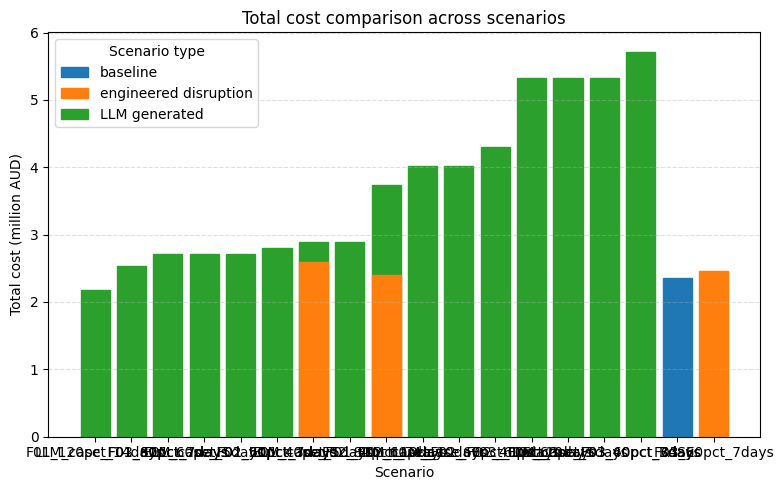

Saved figure 2 to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_scenario_extra_cost_vs_baseline.png


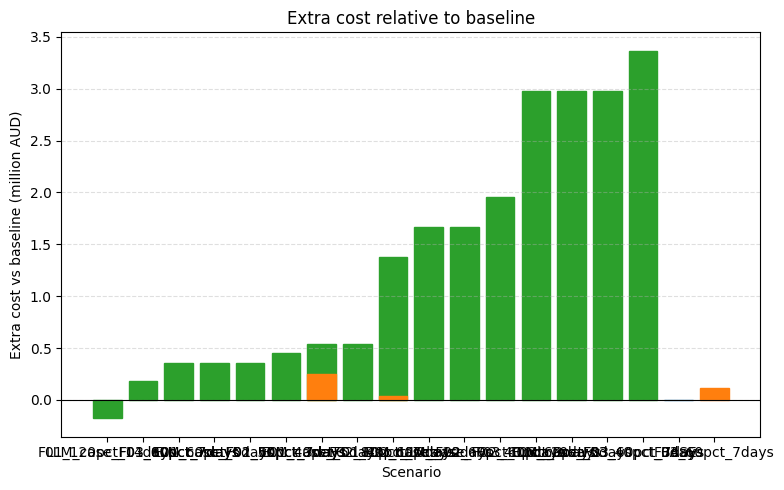

In [15]:
# === Cell 13: Plot main scenario comparison figures ===

import matplotlib.pyplot as plt

# 使用刚才的 tbl_paper，如果不在当前作用域就从 exp_summary_df 重新构建
try:
    tbl_paper
except NameError:
    tbl = exp_summary_df.copy()
    if "total_cost_million_AUD" not in tbl.columns:
        tbl["total_cost_million_AUD"] = tbl["total_cost"] / 1e6
    if "extra_cost_vs_baseline_million_AUD" not in tbl.columns:
        tbl["extra_cost_vs_baseline_million_AUD"] = tbl["extra_cost_vs_baseline"] / 1e6
    baseline_cost = float(tbl.loc[tbl["scenario_type"] == "baseline", "total_cost"].iloc[0])
    tbl["extra_cost_pct_vs_baseline"] = tbl["extra_cost_vs_baseline"] / baseline_cost * 100
    tbl_paper = tbl

# 为了阅读顺序，按 scenario_type + extra_cost 排一下
order = (
    tbl_paper
    .sort_values(["scenario_type", "extra_cost_vs_baseline_million_AUD"])
    .index
)
plot_df = tbl_paper.loc[order].reset_index(drop=True)

# X 轴标签
labels = plot_df["scenario_id"]

# 1) 图 1：总成本（百万 AUD）对比
plt.figure(figsize=(8, 5))
bars = plt.bar(
    labels,
    plot_df["total_cost_million_AUD"],
)

plt.xlabel("Scenario")
plt.ylabel("Total cost (million AUD)")
plt.title("Total cost comparison across scenarios")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# 用不同颜色标出 baseline / engineered / LLM_generated
type_to_color = {
    "baseline": "C0",
    "engineered_disruption": "C1",
    "LLM_generated": "C2",
}
for bar, s_type in zip(bars, plot_df["scenario_type"]):
    bar.set_color(type_to_color.get(s_type, "C7"))

# 做一个手动 legend
handles = []
labels_legend = []
for s_type, color in type_to_color.items():
    handles.append(plt.Rectangle((0, 0), 1, 1))
    handles[-1].set_color(color)
    labels_legend.append(s_type.replace("_", " "))
plt.legend(handles, labels_legend, title="Scenario type")

fig1_path = PROCESSED_DIR / "fig_scenario_total_cost_comparison.png"
plt.tight_layout()
plt.savefig(fig1_path, dpi=300)
print("Saved figure 1 to:", fig1_path)
plt.show()

# 2) 图 2：额外成本（百万 AUD），baseline = 0
plt.figure(figsize=(8, 5))
bars2 = plt.bar(
    labels,
    plot_df["extra_cost_vs_baseline_million_AUD"],
)

plt.xlabel("Scenario")
plt.ylabel("Extra cost vs baseline (million AUD)")
plt.title("Extra cost relative to baseline")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(axis="y", linestyle="--", alpha=0.4)

for bar, s_type in zip(bars2, plot_df["scenario_type"]):
    bar.set_color(type_to_color.get(s_type, "C1"))

fig2_path = PROCESSED_DIR / "fig_scenario_extra_cost_vs_baseline.png"
plt.tight_layout()
plt.savefig(fig2_path, dpi=300)
print("Saved figure 2 to:", fig2_path)
plt.show()


Saved pairwise total-cost figure to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_pairwise_engineered_vs_llm_total_cost.png


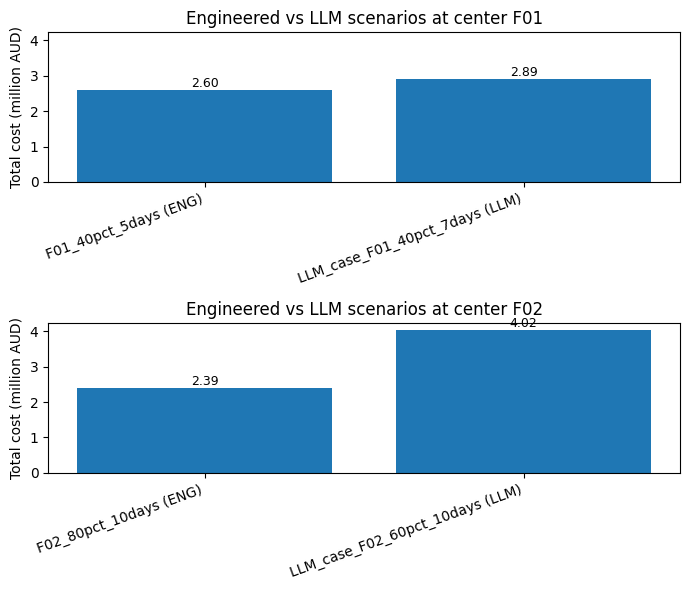

Saved pairwise extra-cost figure to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_pairwise_engineered_vs_llm_extra_cost.png


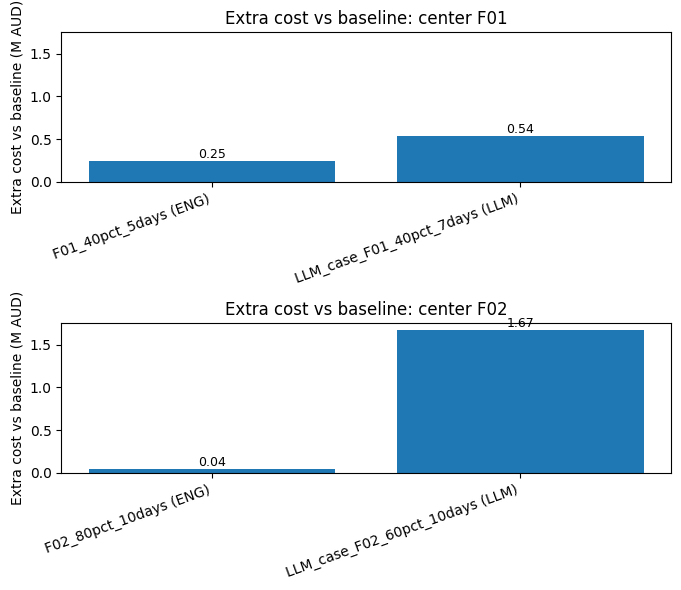

Saved pairwise avg-utilization figure to: D:\Projects\llm_or_project\Notebook1\data\processed\fig_pairwise_engineered_vs_llm_avg_utilization_true.png


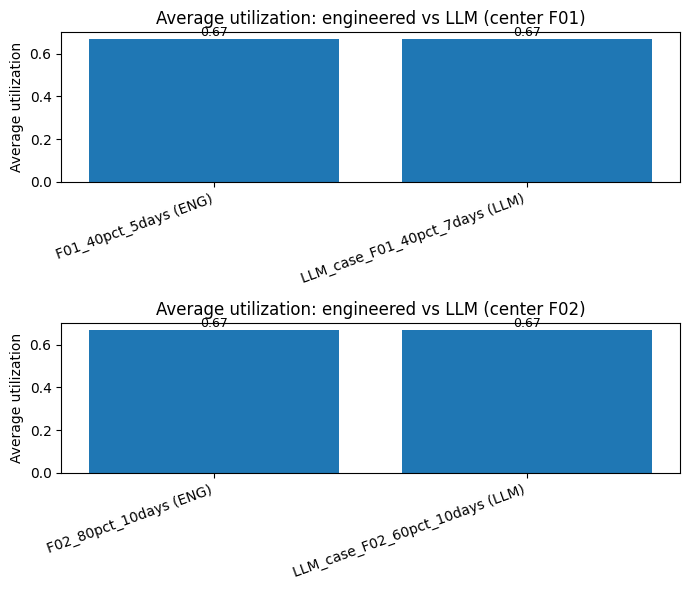

In [16]:
# ==== Cell 14: Engineered vs LLM scenarios – pairwise comparison (F01/F02) ====

import matplotlib.pyplot as plt

# 安全检查
if "exp_summary_df" not in globals():
    raise RuntimeError("exp_summary_df 未找到，请先运行 Cell 11")

# 1) 定义成对的场景（一个工程化 + 一个 LLM）
pair_map = {
    "F01": {  # 受影响中心 F01
        "eng": "F01_40pct_5days",
        "llm": "LLM_case_F01_40pct_7days",
    },
    "F02": {  # 受影响中心 F02
        "eng": "F02_80pct_10days",
        "llm": "LLM_case_F02_60pct_10days",
    }
}

# 简单函数：从 exp_summary_df 里取一行（方便报错）
def get_row_by_id(scenario_id: str):
    rows = exp_summary_df.loc[exp_summary_df["scenario_id"] == scenario_id]
    if rows.empty:
        raise ValueError(f"在 exp_summary_df 中找不到 scenario_id = {scenario_id}")
    return rows.iloc[0]

# ----------------------------------------------------
# (A) 总成本对比（单位：百万 AUD）
# ----------------------------------------------------
fig, axes = plt.subplots(
    nrows=len(pair_map),
    ncols=1,
    figsize=(7, 6),
    sharey=True
)

if len(pair_map) == 1:
    axes = [axes]

for ax, (center, ids) in zip(axes, pair_map.items()):
    eng_id = ids["eng"]
    llm_id = ids["llm"]

    eng_row = get_row_by_id(eng_id)
    llm_row = get_row_by_id(llm_id)

    labels = [f"{eng_id} (ENG)", f"{llm_id} (LLM)"]
    values = [
        eng_row["total_cost_million_AUD"],
        llm_row["total_cost_million_AUD"],
    ]

    x = range(2)
    bars = ax.bar(x, values)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha="right")
    ax.set_ylabel("Total cost (million AUD)")
    ax.set_title(f"Engineered vs LLM scenarios at center {center}")

    for b, v in zip(bars, values):
        ax.text(
            b.get_x() + b.get_width() / 2,
            v,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

fig.tight_layout()
fig_path_total = PROCESSED_DIR / "fig_pairwise_engineered_vs_llm_total_cost.png"
fig.savefig(fig_path_total, dpi=300, bbox_inches="tight")
print("Saved pairwise total-cost figure to:", fig_path_total)
plt.show()

# ----------------------------------------------------
# (B) 相对基线的额外成本对比（单位：百万 AUD）
# ----------------------------------------------------
fig, axes = plt.subplots(
    nrows=len(pair_map),
    ncols=1,
    figsize=(7, 6),
    sharey=True
)

if len(pair_map) == 1:
    axes = [axes]

for ax, (center, ids) in zip(axes, pair_map.items()):
    eng_id = ids["eng"]
    llm_id = ids["llm"]

    eng_row = get_row_by_id(eng_id)
    llm_row = get_row_by_id(llm_id)

    labels = [f"{eng_id} (ENG)", f"{llm_id} (LLM)"]
    values = [
        eng_row["extra_cost_vs_baseline_million_AUD"],
        llm_row["extra_cost_vs_baseline_million_AUD"],
    ]

    x = range(2)
    bars = ax.bar(x, values)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha="right")
    ax.set_ylabel("Extra cost vs baseline (M AUD)")
    ax.set_title(f"Extra cost vs baseline: center {center}")

    for b, v in zip(bars, values):
        ax.text(
            b.get_x() + b.get_width() / 2,
            v,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

fig.tight_layout()
fig_path_extra = PROCESSED_DIR / "fig_pairwise_engineered_vs_llm_extra_cost.png"
fig.savefig(fig_path_extra, dpi=300, bbox_inches="tight")
print("Saved pairwise extra-cost figure to:", fig_path_extra)
plt.show()

# ----------------------------------------------------
# (C) 平均利用率对比（使用各自场景的 util_df 计算出的 avg_utilization）
# ----------------------------------------------------
fig, axes = plt.subplots(
    nrows=len(pair_map),
    ncols=1,
    figsize=(7, 6),
    sharey=True
)

if len(pair_map) == 1:
    axes = [axes]

for ax, (center, ids) in zip(axes, pair_map.items()):
    eng_id = ids["eng"]
    llm_id = ids["llm"]

    eng_row = get_row_by_id(eng_id)
    llm_row = get_row_by_id(llm_id)

    labels = [f"{eng_id} (ENG)", f"{llm_id} (LLM)"]
    values = [
        eng_row["avg_utilization"],
        llm_row["avg_utilization"],
    ]

    x = range(2)
    bars = ax.bar(x, values)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha="right")
    ax.set_ylabel("Average utilization")
    ax.set_title(f"Average utilization: engineered vs LLM (center {center})")

    for b, v in zip(bars, values):
        ax.text(
            b.get_x() + b.get_width() / 2,
            v,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

fig.tight_layout()
fig_path_util = PROCESSED_DIR / "fig_pairwise_engineered_vs_llm_avg_utilization_true.png"
fig.savefig(fig_path_util, dpi=300, bbox_inches="tight")
print("Saved pairwise avg-utilization figure to:", fig_path_util)
plt.show()


In [18]:
from pathlib import Path
import pandas as pd

# === 0. 配置：目标要多少个 engineered / LLM 场景 ===
TARGET_ENG = 5   # 你希望最终论文中保留的 engineered_disruption 数量
TARGET_LLM = 6   # 你希望最终论文中保留的 LLM_generated 数量
BASELINE_ID = "BASE"

PROCESSED_DIR = Path(r"D:\Projects\llm_or_project\Notebook1\data\processed")
MASTER_CSV = PROCESSED_DIR / "tbl_experiment_summary_all_scenarios.csv"
FINAL_CSV  = PROCESSED_DIR / "tbl_experiment_summary_FINAL.csv"

# === 1. 读取 master CSV，并按 scenario_id 去重 ===
exp_all_raw = pd.read_csv(MASTER_CSV)

print("正在读取 master CSV:", MASTER_CSV)
print("master 原始总行数(含 baseline)：", len(exp_all_raw))

# 按 scenario_id 去重：同一个 ID 只保留最后一条记录
exp_all = (
    exp_all_raw
    .drop_duplicates(subset="scenario_id", keep="last")
    .reset_index(drop=True)
)

print("按 scenario_id 去重后的行数：", len(exp_all))

print("\n当前 scenario_type 统计（去重后，仅供参考）：")
print(exp_all["scenario_type"].value_counts())

all_ids = exp_all["scenario_id"].tolist()
master_ids = set(all_ids)
print("\n当前 scenario_id 列表：")
print(all_ids)

# === 2. 按命名规则，从 master 中分出“工程化候选”和“LLM候选” ===
eng_candidates = sorted(
    [sid for sid in master_ids
     if (sid.startswith("F01_") or sid.startswith("F02_") or sid.startswith("F03_"))]
)
llm_candidates = sorted(
    [sid for sid in master_ids
     if sid.startswith("LLM_case_")]
)

print("\n自动识别到的 engineered 候选(按字母排序)：", eng_candidates)
print("自动识别到的 LLM 候选(按字母排序)：", llm_candidates)

if len(eng_candidates) < TARGET_ENG:
    raise ValueError(
        f"工程化候选只有 {len(eng_candidates)} 个，不足 {TARGET_ENG} 个，"
        f"请先在实验中多生成几条 engineered 场景。"
    )

if len(llm_candidates) < TARGET_LLM:
    raise ValueError(
        f"LLM 候选只有 {len(llm_candidates)} 个，不足 {TARGET_LLM} 个，"
        f"请先在实验中多生成几条 LLM 场景。"
    )

# === 3. 自动选出最终的 5 个 eng + 6 个 LLM ===
eng_F01 = [sid for sid in eng_candidates if sid.startswith("F01_")]
eng_F02 = [sid for sid in eng_candidates if sid.startswith("F02_")]
eng_F03 = [sid for sid in eng_candidates if sid.startswith("F03_")]

FINAL_ENG_IDS = []

if eng_F01:
    FINAL_ENG_IDS.append(eng_F01[0])
if eng_F02:
    FINAL_ENG_IDS.append(eng_F02[0])
if eng_F03:
    FINAL_ENG_IDS.append(eng_F03[0])

remaining_eng = [sid for sid in eng_candidates if sid not in FINAL_ENG_IDS]
need_more = TARGET_ENG - len(FINAL_ENG_IDS)
if need_more > 0:
    FINAL_ENG_IDS += remaining_eng[:need_more]

FINAL_ENG_IDS = FINAL_ENG_IDS[:TARGET_ENG]  # 保险

FINAL_LLM_IDS = llm_candidates[:TARGET_LLM]

print("\n选出的 FINAL_ENG_IDS =", FINAL_ENG_IDS)
print("选出的 FINAL_LLM_IDS =", FINAL_LLM_IDS)

# === 4. 组装最终 ID 列表，并检查是否都在 master 里 ===
FINAL_IDS = [BASELINE_ID] + FINAL_ENG_IDS + FINAL_LLM_IDS
print("\n最终预期场景数:", len(FINAL_IDS),
      "(1 baseline +", len(FINAL_ENG_IDS), "eng +", len(FINAL_LLM_IDS), "LLM)")
print("FINAL_IDS =", FINAL_IDS)

missing = [sid for sid in FINAL_IDS if sid not in master_ids]
if missing:
    raise ValueError(
        "❌ 下面这些 FINAL_IDS 在 master CSV 中不存在，请检查拼写，或者先在实验中生成：\n"
        f"   {missing}"
    )

# === 5. 从 master 过滤出这 1 + 5 + 6 条，并重写 scenario_type ===
exp_final = exp_all[exp_all["scenario_id"].isin(FINAL_IDS)].copy()

# 统一重写类型：先全部设为 LLM，再覆盖 baseline / eng
exp_final["scenario_type"] = "LLM_generated"
exp_final.loc[exp_final["scenario_id"] == BASELINE_ID, "scenario_type"] = "baseline"
exp_final.loc[exp_final["scenario_id"].isin(FINAL_ENG_IDS), "scenario_type"] = "engineered_disruption"
exp_final.loc[exp_final["scenario_id"].isin(FINAL_LLM_IDS), "scenario_type"] = "LLM_generated"

# === 6. 用“唯一 scenario_id 数量”做结构断言 ===
n_base = exp_final[exp_final["scenario_type"] == "baseline"]["scenario_id"].nunique()
n_eng  = exp_final[exp_final["scenario_type"] == "engineered_disruption"]["scenario_id"].nunique()
n_llm  = exp_final[exp_final["scenario_type"] == "LLM_generated"]["scenario_id"].nunique()

assert n_base == 1, "baseline 场景不是 1 个！"
assert n_eng  == TARGET_ENG, f"engineered 场景不是 {TARGET_ENG} 个！"
assert n_llm  == TARGET_LLM, f"LLM 场景不是 {TARGET_LLM} 个！"

print("\n✅ 结构检查通过：1 baseline +", TARGET_ENG, "eng +", TARGET_LLM, "LLM")

# === 7. 排序 + 保存 FINAL CSV（以后所有 notebook 只读这个） ===
exp_final["scenario_type"] = pd.Categorical(
    exp_final["scenario_type"],
    categories=["baseline", "engineered_disruption", "LLM_generated"],
    ordered=True,
)
exp_final = exp_final.sort_values(["scenario_type", "scenario_id"]).reset_index(drop=True)

print("\nFINAL 表 scenario_type 统计：")
print(exp_final["scenario_type"].value_counts())
print("\nFINAL scenario_id 列表：")
print(exp_final["scenario_id"].tolist())

exp_final.to_csv(FINAL_CSV, index=False, encoding="utf-8-sig")
print("\n✅ 已保存 FINAL 场景表到:", FINAL_CSV)
print("   最终行数 =", len(exp_final))


正在读取 master CSV: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_experiment_summary_all_scenarios.csv
master 原始总行数(含 baseline)： 20
按 scenario_id 去重后的行数： 18

当前 scenario_type 统计（去重后，仅供参考）：
scenario_type
LLM_generated            16
baseline                  1
engineered_disruption     1
Name: count, dtype: int64

当前 scenario_id 列表：
['BASE', 'F03_60pct_7days', 'F01_120pct_14days', 'LLM_case_F03_80pct_7days', 'F01_60pct_7days', 'F01_60pct_5days', 'LLM_case_F01_60pct_7days', 'F02_50pct_3days', 'F01_40pct_5days', 'LLM_case_F01_40pct_7days', 'F02_80pct_10days', 'F02_60pct_10days', 'LLM_case_F02_60pct_10days', 'LLM_case_F02_40pct_10days', 'F03_60pct_3days', 'F03_60pct_5days', 'LLM_case_F03_60pct_7days', 'F03_40pct_3days']

自动识别到的 engineered 候选(按字母排序)： ['F01_120pct_14days', 'F01_40pct_5days', 'F01_60pct_5days', 'F01_60pct_7days', 'F02_50pct_3days', 'F02_60pct_10days', 'F02_80pct_10days', 'F03_40pct_3days', 'F03_60pct_3days', 'F03_60pct_5days', 'F03_60pct_7days']
自动识别到的 LLM 候选(按字母排序)： ['